In our journey to find the magic, @meylone and I explored one aspect of what a decision tree based algorithm cannot see in [What a decision tree cannot see?](https://www.kaggle.com/mhviraf/what-a-decision-tree-cannot-see) kernel. In this kernel we are going to explore another aspect of what a decision tree based algorithm cannot see. **Feature interactions**!

As discussed in many other kernels, decision trees split the variables one by one. For example, look at the tree below which resulted in AUC of 0.60348. It starts with `var_81` then continues by spliting `var_12` and so on so forth. 

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold,KFold,train_test_split, train_test_split
from six.moves import urllib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, mode
from sklearn import tree

from sklearn.ensemble import RandomForestRegressor


from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source

np.random.seed(seed=2019)

In [2]:
train = pd.read_csv('../input/train.csv')
train, target = train.iloc[:, 2:], train['target']

CV score: 0.60348 


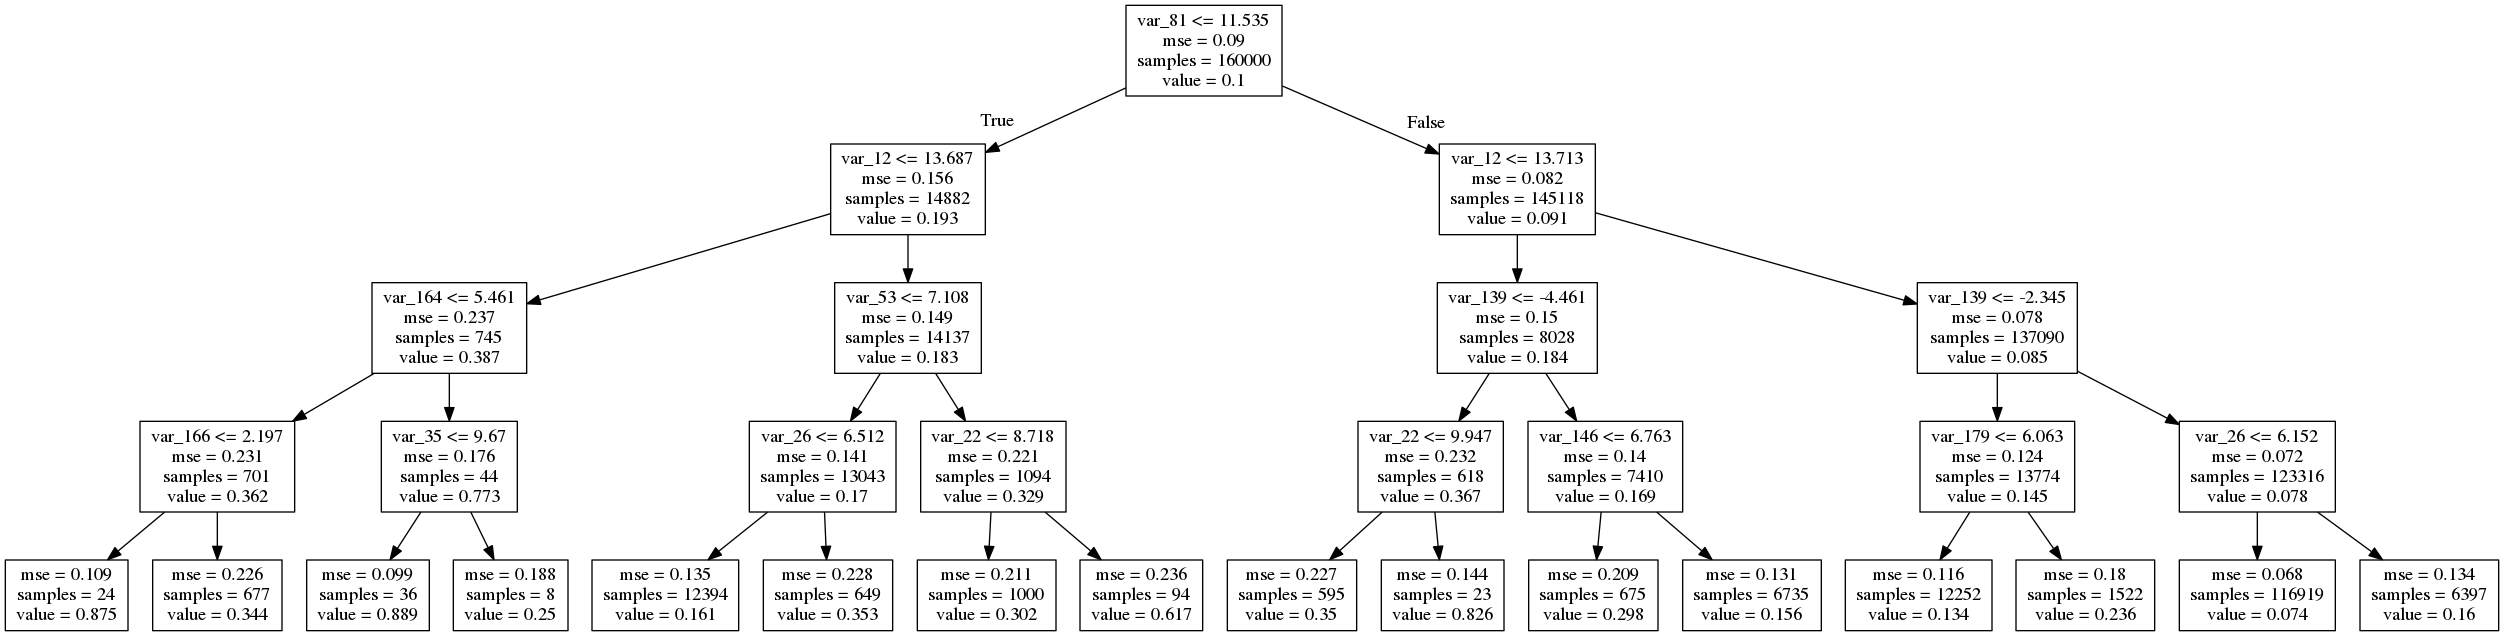

In [3]:
X = train
y = target
#print(' based on ' + str(X.shape[1]) + ' features')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2019)


dtree=DecisionTreeRegressor(max_depth=4)
dtree.fit(X_train,y_train)
y_valid_pred = dtree.predict(X_valid)
print("CV score: {:<8.5f}".format(roc_auc_score(y_valid, y_valid_pred)))

graph = Source(tree.export_graphviz(dtree, out_file=None, feature_names=X.columns))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

The above tree is the fundamental block of LightGBM, XGBoost, RandomForest, and Catboost. To get a sense of how feature interactions would affect a decision tree based algorithm, I have also trained a simple random forest before I add feature interactions and it resulted in AUC of 0.65519 in a 5 fold cross validation. 

In [4]:
num_folds = 5

X = train
y = target

folds = KFold(n_splits=num_folds, random_state=2019)
oof = np.zeros(len(X))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X.values, y.values)):
    X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    
    model = RandomForestRegressor(n_estimators=10, max_depth=4).fit(X_train, y_train)
#     print("fold " + str(fold_+1) + " training score: {:<8.5f}".format(roc_auc_score(y_train, model.predict(X_train))))
#     print("fold " + str(fold_+1) + " validation score: {:<8.5f}".format(roc_auc_score(y_valid, model.predict(X_valid))))
    oof[val_idx] = model.predict(X.iloc[val_idx])
    
print("CV score: {:<8.5f}".format(roc_auc_score(y, oof)))

CV score: 0.65519 


Now, I want to explore some feature interactions including:
* norm of features
* mean of features
* different percentiles of features

Notice that these simple summary statistics are row-wised and I used two different scaling methods before taking those measurements. Below you can find the distributions for every class of these features:

In [5]:
# feature engineering section - 4 new features added
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# scaling
ss=StandardScaler()
mms=MinMaxScaler()

Xs=ss.fit_transform(train)
Xmm=mms.fit_transform(train)

In [6]:
def plot_dists(feature_name):
    #plot of distributions
    plt.figure()
    plt.title(feature_name + ' - StandardScaler')
    sns.kdeplot(train.loc[target==0, feature_name + '_s'], label='class 0', color='red')
    sns.kdeplot(train.loc[target==1, feature_name + '_s'], label='class 1', color='blue')
    plt.figure()
    plt.title(feature_name + ' - MinMaxScaler')
    sns.kdeplot(train.loc[target==0, feature_name + '_m'], label='class 0', color='red')
    sns.kdeplot(train.loc[target==1, feature_name + '_m'], label='class 1', color='blue')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


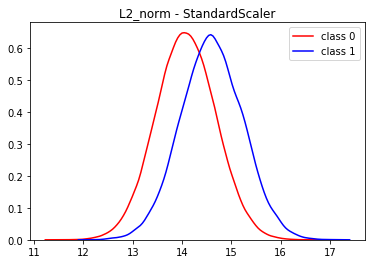

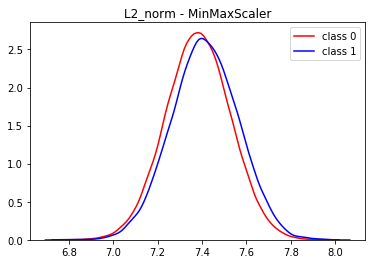

In [10]:
# norms
feature_name = 'L2_norm'

train[feature_name + '_s']=np.linalg.norm(Xs,axis=1, ord=2)
train[feature_name + '_m']=np.linalg.norm(Xmm,axis=1, ord=2)

plot_dists(feature_name)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


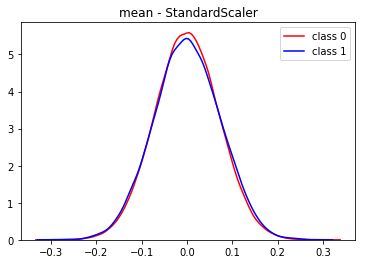

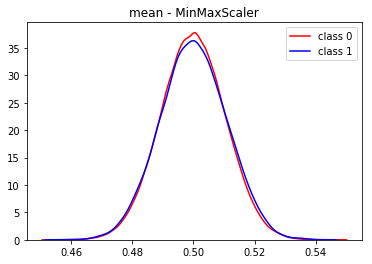

In [11]:
# means
feature_name = 'mean'

train[feature_name + '_s']=Xs.mean(axis=1)
train[feature_name + '_m']=Xmm.mean(axis=1)

plot_dists(feature_name)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


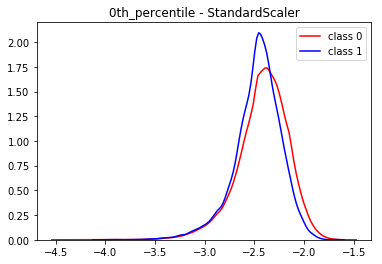

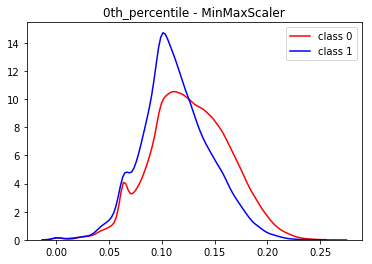

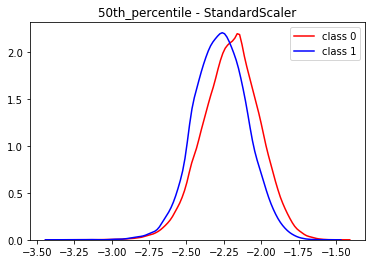

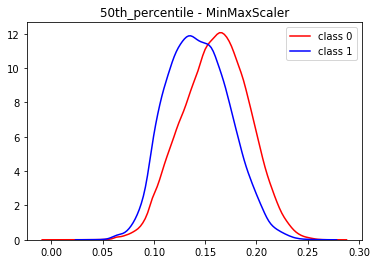

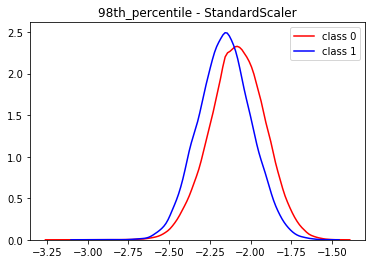

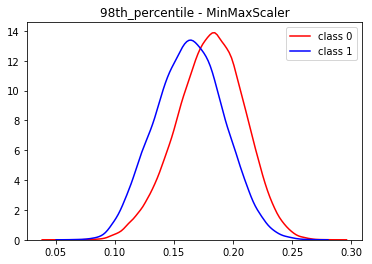

In [12]:
def generate_percentile(percentile, show_plot=False):
    percentile = percentile/100
    feature_name = str(int(percentile*100)) + 'th_percentile'

    train[feature_name + '_s']= np.percentile(Xs, q=percentile, axis=1)
    train[feature_name + '_m']= np.percentile(Xmm, q=percentile, axis=1)
    
    if show_plot:
        plot_dists(feature_name)
    
generate_percentile(0, show_plot=True) # min
generate_percentile(2)
generate_percentile(5)
generate_percentile(10)
generate_percentile(15)
generate_percentile(25)
generate_percentile(50, show_plot=True) # median
generate_percentile(75)
generate_percentile(85)
generate_percentile(95)
generate_percentile(98, show_plot=True)
generate_percentile(100) # maximum

If I were a decision tree I would have said that by looking at the distributions of some of these generated features such as 98th percentile, median (or 50th percentile) and L2_norm of StandardScaler I can make good splits :)

let's build a decision tree using old features along with these new features and see what a real decision tree thinks of these feature. 

AUC score jumped to 0.73147! Also, look at the tree below; many of the features we generated were chosen by the tree to make the splits at the very top of the tree! So, great! we introduced new features that couldn't have been identified by the tree itself and it increased the AUC score.

 based on 228 features
CV score: 0.73147 


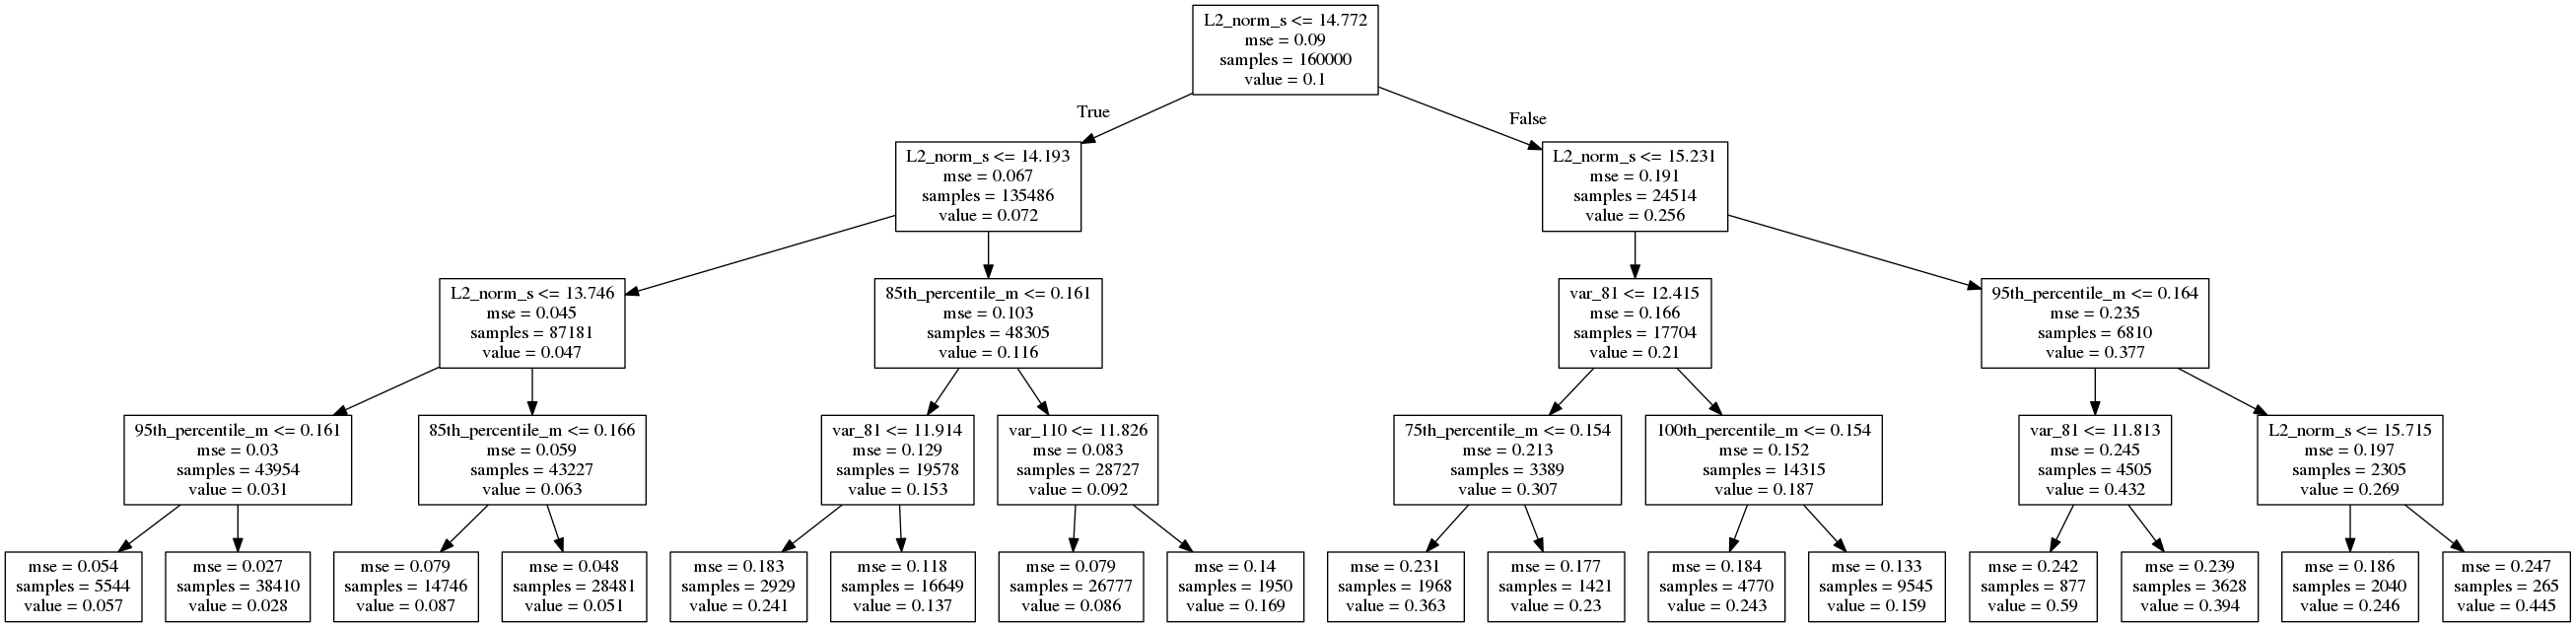

In [13]:
X = train
y = target
#print(' based on ' + str(X.shape[1]) + ' features')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2019)


dtree=DecisionTreeRegressor(max_depth=4)
dtree.fit(X_train,y_train)
y_valid_pred = dtree.predict(X_valid)
print("CV score: {:<8.5f}".format(roc_auc_score(y_valid, y_valid_pred)))

graph = Source(tree.export_graphviz(dtree, out_file=None, feature_names=X.columns))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

Let us see wheter this conclusion works also in an ensemble of trees like a RandomForest regressor similar to the one above?

I trained the exact same random forest as before on this dataset (including original dataset and these added features) and  it resulted in an increased AUC of 0.74056 in a 5 fold cross validation. 

In [14]:
num_folds = 5

X = train
y = target

folds = KFold(n_splits=num_folds, random_state=2019)
oof = np.zeros(len(X))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X.values, y.values)):
    X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    
    model = RandomForestRegressor(n_estimators=10, max_depth=4).fit(X_train, y_train)
#     print("fold " + str(fold_+1) + " training score: {:<8.5f}".format(roc_auc_score(y_train, model.predict(X_train))))
#     print("fold " + str(fold_+1) + " validation score: {:<8.5f}".format(roc_auc_score(y_valid, model.predict(X_valid))))
    oof[val_idx] = model.predict(X.iloc[val_idx])
    
print("CV score: {:<8.5f}".format(roc_auc_score(y, oof)))

CV score: 0.74056 


These types of features seemed very promising to me :) I thought I have found the magic at the beginning! but it turned out that these features are not the magical ones. Although I still suspect that it has something to do with these sort of stuff. Anyway, we will find out in a few hours after the top ranks (hopefully) share their magic with us.

Finally, it was a good run. I learned a lot in this competition and I shared parts of it with you too. Good luck!